# Assignment 3 CS 5316 Natural Language Processing
For this assignment we will use the following packages
<ul>
    <li><a href="https://radimrehurek.com/gensim/">Gensim</a>.</li>
    <li><a href="https://keras.io/">Keras</a>.</li>
    <li><a href="https://www.tensorflow.org/">Tensorflow</a>.</li>
</ul>
You can install these packages via anaconda navigator or use the conda install / pip install commands e.g<br>
<blockquote>pip install gensim<br>
pip install tensorflow<br>
pip install keras</blockquote>

In [41]:
import numpy as np
from IPython.display import Image
# Get the interactive Tools for Matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.decomposition import PCA
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.decomposition import TruncatedSVD
from sklearn.utils.extmath import randomized_svd
import nltk
from nltk import ngrams
import pandas as pd
import seaborn as sn

### Preprocessing
Since we have already discussed preprocessing trade off's in previous assingments. We expect you to analyse the data and preform the preprocessing that is required.<br> 

In [42]:
#load the dataset
def load_data(filename):
    """
    Load data from file

    Args:
        filename : Name of the file from which the data is to be loaded
    
    Returns: tweet_X, sentiment_Y
    tweet_X: list of tweets
    sentiment_Y: list of sentiment lables correponding to each tweet
    """
    data = pd.read_csv(filename)
    X = data["text"]
    Y = data["class"]
    return X, Y
raw_tweets, labels = load_data("twitter-sanders-apple3.csv")
print(len(raw_tweets), len(labels))

988 988


In [43]:
import re
def preprocess(tweet):
    processed_data = tweet.lower()
    processed_data = re.sub("@[\S]+", "AT_TOKEN", processed_data)
    processed_data = re.sub("[#]", "", processed_data)
    processed_data = re.sub("<.*>", "", processed_data)
    processed_data = re.sub("[^a-zA-Z0-9\s_]", " ", processed_data)
    processed_data = re.sub("[\s]+", " ", processed_data)
    processed_data = re.sub("[_]{2,10}", "", processed_data)
    processed_data = processed_data.split(" ")
    return [x for x in processed_data if len(x)]
def preprocessing(data):
    """
    Perform preprocessing of the tweets

    Args:
        data : list of tweets
    
    Returns: data: preprocessed list of tweets
    """
#     return [preprocess(data[0])]
    new_data = [preprocess(x) for x in data]
    tokens = list(sum(new_data, []))
    for i in range(0, len(new_data)):
        for j in range(0, len(new_data[i])):
            if tokens.count(new_data[i][j]) == 1:
                new_data[i][j] = 'UNK'
    print(len(set(sum(new_data, []))))
    return new_data
    
tweets = preprocessing(raw_tweets)
print(len(tweets), tweets[0])
X_train = tweets

1317
988 ['now', 'all', 'AT_TOKEN', 'has', 'to', 'do', 'is', 'get', 'UNK', 'on', 'the', 'iphone', 'and', 'it', 'will', 'be', 'crack', 'iphone', 'that', 'is']


### Test train split
Use test train split from sklearn.


In [44]:
from sklearn.model_selection import train_test_split
def testTrainSplit(data_X,data_Y):
    """
    Return test train data

    Args:
        data_X : reviews
        data_Y: labels
    Returns: test train split data 
    """
    X_train, X_test, y_train, y_test = train_test_split(tweets, labels, test_size=0.15, random_state=0)
    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = testTrainSplit(tweets, labels)
print(X_train[0])

['AT_TOKEN', 'haven', 't', 'had', 'a', 'chance', 'to', 'check', 'out', 'the', 'android', 'UNK', 'but', 'UNK', 'are', 'likely', 'a', 'UNK', 'to', 'AT_TOKEN', 'newsstand', 'UNK', 'into', 'ios5']


Extract the vocabulary, to find te dimensions of co-occurance matrix

In [45]:
def getVocabulary(train_X):
    """
    Return dataset vocabulart

    Args:
        train_X : reviews in train dataset
    
    Returns: vocabulary
    vocabulary: list of unique words in dataset
    """
    vocab = list(set(list(sum(train_X, []))))
    return vocab
vocabulary = getVocabulary(X_train)
print(len(vocabulary))

1303


### Point Wise Mutial Information
Pointwise mutual information, or PMI, is the (unweighted) term that occurs inside of the summation of mutual information and measures the correlation between two specific events. Specifically, PMI is defined as<br>
$$PMI(a, b) = \log \frac{p(a,b)}{p(a)p(b)}$$

and measures the (log) ratio of the joint probability of the two events as compared to the joint probability of the two events assuming they were independent. Thus, PMI is high when the two events a and b co-occur with higher probability than would be expected if they were independent.

If we suppose that a and b are words, we can measure how likely we see a and b together compared to what we would expect of they were unrelated by computing their PMI under some model for the joint probability $$p(a,b)$$

Let D represent a collection of observed word-context pairs (with contexts being other words). We can construct D by considering the full context of a specific word occurrence as the collection of all word occurrences that appear within a fixed-size window of length L before and after it.

For a specific word $w_i$ in position i in a large, ordered collection of words $w_1, w_2$, we would have the context as ,$w_{i-1},w_{i+1},\ldots$, and could thus collect counts (a total of 2L) of each of those words as appearing in the context of word $w_i$. We will refer to $w_i$ as the “target word” and the words appearing in the L-sized window around $w_i$ as “context words”.

Consider a sample corpus containing only one sentence:<br>
    <center><blockquote>Encumbered forever by desire and ambition</blockquote></center>

We can construct D by considering each word position i and extracting the pairs $(w_i, w_{i+k})$ for $−L≤k≤L;k≠0$. In such a pair, we would call $w_i$ the “target word” and $w_{i+k}$ the “context word”.

For example, we would extract the following pairs for $i=4i$ if we let our window size $L=2$<br>
    <center><blockquote>(desire,forever),(desire,by),(desire,and),(desire,ambition)</blockquote></center>

Similarly, for $i=5i$, we would extract the following pairs:
    <center><blockquote>(and,by),(and,desire),(and,ambition)</blockquote></center>
Let’s let $n_{w,c}$ represent the number of times we observe word type c in the context of word type w. We can then define ,$n_w = \sum_{c'} n_{w,c'}$ as the number of times we see a “target” word w in the collection of pairs D and $n_c = \sum_{w'} n_{w',c}$ as the number of times we see the context word c in the collection of pairs D.

We can then define the joint probability of a word and a context word as
    $$p(w, c) = \frac{n_{w,c}}{|D|}$$

where $∣D∣$ is simply the total number of word-context occurrences we see. Similarly, we can define
    $$p(w) = \frac{n_w}{|D|}$$

and $$p(c) = \frac{n_c}{|D|}$$

and thus the PMI between a word w and context word c is
$$PMI(w, c) = \log \frac{p(w,c)}{p(w)p(c)} = \log \frac{n_{w,c} \cdot |D|}{n_w \cdot n_c}.$$

If we compute the PMI between all pairs of words in our vocabulary V, we will arrive at a large, real-valued matrix. However, some of the values of this matrix will be $\log 0$, if the word-context pair $(w,c)$ is unobserved, this will result in inf bieng computed. To remedy this, we could simply define a modified PMI that is equal to 0 when $n_{w,c} = 0$, which is the positive pointwise mutual information (PPMI) which:
    P$$PPMI(w,c) = \max(0, PMI(w,c))$$
<br>
This wonderfull explaination is made by <a href="http://czhai.cs.illinois.edu/">Dr.ChengXiang ("Cheng") Zhai</a><br><br>

<center><b>HINT: Consult your slides and see the example, how the formulas are used. You can calculate $|D|$ by the formula given in the slides(its the same thing).</b></center>

If youre having troubles implementing this here is some [motivation](https://www.youtube.com/watch?v=TsyM5jP7RQk)

### Create a co-occurance matrix with +,- k window size
Hint: Use the ngrams package from [nltk](https://www.nltk.org/) to make life easier. Matrix size is vocab X vocab.
Please keep track of the order of words in the matrix this will be usefull later.

In [46]:
def com_single_tweet(tweet, vocab, k, mat):
    all_grams = []
    for i in range(2, k+2):
        grams = list(ngrams(tweet, i))
        grams = [tuple(sorted((x[0], x[-1]))) for x in grams] #I do not need middle elements of ngrams \
                                    #and (x, y) should be considered same as (y, x) for count in matrix
        all_grams += grams
    dist = nltk.FreqDist(all_grams)
    for i in range(0, mat.shape[0]):
        for j in range(0, mat.shape[1]):
            mat[i, j] += dist[(vocab[i], vocab[j])]
    return mat
def coOccuranceMatrix(train_X,vocab,k=2):
    """
    Return co-occurance matrix with ppmi counts
    Args:
        data : dataset
        vocab : vocabulary
    Returns: co_matrix
    co_matrix: co-occurance matrix
    """
    co_occurrence_matrix = np.zeros((len(vocab), len(vocab)))
    count = 0
    print("Calculating co-occurences")
    for tweet in train_X:
        co_occurrence_matrix = com_single_tweet(tweet, vocab, k, co_occurrence_matrix)
    return co_occurrence_matrix

# Following line takes a lot of time so instead use the saved matrix
cooc_matrix = coOccuranceMatrix(X_train, vocabulary, 2)


# from numpy import loadtxt
# cooc_matrix = loadtxt('cooc_matrix.csv', delimiter=',')

In [47]:
saved_matrix = cooc_matrix
print(saved_matrix.shape)
def ppmiMatrix(co_matrix):
    """
    Return co-occurance matrix with ppmi counts

    Args:
        co_matrix : co-occurance matrix
    Returns: ppmi_matrix
    ppmi_co_matrix: co-occurance matrix with ppmi counts
    """
    ppmi_co_matrix = np.zeros((co_matrix.shape[0], co_matrix.shape[1]))
    ncs = np.sum(co_matrix, axis = 0) #sum the columns and out a row
    nws = np.sum(co_matrix, axis = 1) # sum the rows and output a column
    D = sum(ncs)
    print(sum(ncs), sum(nws))
    for i in range(0, co_matrix.shape[0]):
        for j in range(0, co_matrix.shape[1]):
            nwc = co_matrix[i, j]
            if nwc != 0:
                nc = ncs[j]
                nw = nws[i]
                tmp = min(0, np.log((nwc*D)/(nw*nc)))
                ppmi_co_matrix[i, j] = tmp
            else:
                ppmi_co_matrix[i, j] = 0
    return ppmi_co_matrix
ppm = ppmiMatrix(saved_matrix)

(1303, 1303)
27153.0 27153.0


In [48]:
ppm

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Code for SVD has been provided for you, all you have to do is specify the number of top eigenvalues or how many top <b>n</b> dimensions you want to keep. Check the dimensions of the returned matrix by using <blockquote>.shape</blockquote> command to figure out if the embedding for each word is in row or column. By our calculation the vocab count should be less than five thousand, reduce the dimensionality to less than one thousand.

In [49]:
EMB_SIZE = 950
#code provided 
def denseMatrixViaSVD(ppmi_co_matrix,n):
    """
    Return reduced dimensionality co-occurance matrix by applying svd

    Args:
        ppmi_matrix : co-occurance matrix with ppmi counts
        
    Returns: svd_co_matrix
    svd_co_matrix: reduced dimensionality co-occurance matrix
    """
#     top_n_eigenvalues=
    U, Sigma, VT = randomized_svd(ppmi_co_matrix, 
                              n_components=n,
                              n_iter=5,
                              random_state=None)
    svd_co_matrix=U
    return svd_co_matrix
dmvs = denseMatrixViaSVD(ppm, EMB_SIZE)
print(dmvs.shape)
print(ppm.shape)
#each row is a word

(1303, 950)
(1303, 1303)


### Modelling
Now that we have our embeddings, lets use these to train a Feed Forward Neural network for our semantic classification task. Since a feed forward network's input layer is of a fixed size we will need to create a fixed size representation for each review. For this purpose we will use the following:
<ul>
    <li>Average pooling.</li>
    <li>Averaging pooling algorithm by FastText(provided)</li>
    <li>Max pooling. </li>
</ul>
For those of you who are familiar with Convolution Neural Networks this pooling will be a 1d pooling operation. See illustrated example below:<img src="pooling.png">

Since we cant have a tutorial due to corona virus for keras, a simple feed forward network has beed provided for you. You need to create train_X, test_X , train_Y and test_Y these should numpy arrays inorder for keras to use them.
<ul>
    <li>train_X= contains embedding representains of all the reviews in the train set</li>
    <li>train_Y= contains embedding representains of all the reviews in the test set</li>
    <li>train_Y= contains <b>one hot</b> representations of train labels</li>
    <li>test_Y= contains <b>one hot</b> representations of test labels</li>   
</ul>
To construct one hot representation you can use the sklearn's preprocessing package or the preprocessing package from keras. Read online.

In [50]:
# CONSTRUCT ONE HOT REPRESENTATION
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
train_labels = enc.fit_transform([[x] for x in y_train]).toarray()
test_labels = enc.transform([[x] for x in y_test]).toarray()
# print(y_train[:20], train_labels[:20])

In [51]:
def create_X_train(X, word_embs, vocab, pooling_func):
    tweet_vectors = []
    for tweet in X:
        tmp_tweet = []
        for word in tweet:
            tmp_tweet += [word_embs[vocab.index(word)]]
        tmp_tweet = np.array(tmp_tweet)
        pooled_tweet = pooling_func(tmp_tweet, tmp_tweet.shape)
        tweet_vectors += [pooled_tweet]
    return np.array(tweet_vectors)

In [52]:
#Fast text averaging, pass a list of word embeddings and embedding size to fasttextAveraging function
def l2_norm(x):
   return np.sqrt(np.sum(x**2))

def div_norm(x):
   norm_value = l2_norm(x)
   if norm_value > 0:
       return x * ( 1.0 / norm_value)
   else:
       return x
def fasttextAveraging(embedding_list,embedding_size):
    norm=np.zeros(embedding_size)
    for emb in embedding_list:
        norm=norm+div_norm(emb)
    return norm/len(embedding_list)

fta_X_train = create_X_train(X_train, dmvs, vocabulary, fasttextAveraging)
# print(len(fta_X_train[1]))

In [53]:
def averagePooling(embedding_list,embedding_size):
    """
    Return average embedding vector from list of embedding
    Args:
        embedding_list : embedding list
        embedding_size: size of embedding vector
    Returns: average_embedding
    average_embedding: average embedding vector
    """
    res = np.zeros(embedding_size[1])
    for i in range(0, embedding_size[1]):
        res[i] = np.mean(embedding_list[:, i])
    return res

ap_X_train = create_X_train(X_train, dmvs, vocabulary, averagePooling)
print(len(ap_X_train))

839


In [54]:
def maxPooling(embedding_list,embedding_size):
    """
    Return maxpooling embedding vector from list of embedding
    Args:
        embedding_list : embedding list
        embedding_size: size of embedding vector
    Returns: max_embedding
    max_embedding: maxpooled embedding vector
    """
    res = np.zeros(embedding_size[1])
    for i in range(0, embedding_size[1]):
        res[i] = max(embedding_list[:, i])
    return res
mp_X_train = create_X_train(X_train, dmvs, vocabulary, maxPooling)
print(len(mp_X_train))

print(mp_X_train.shape, "\n", train_labels.shape)

839
(839, 950) 
 (839, 3)


Try using all three representaions to train the model and check which one works best. You can play around with embedding size by controlling <b>n</b> in SVD function and for the model you can add or remove layers or change the number of neurons in the hidden layers. Keep in mind that the layers should be decreasing in size as we go deeper into the network, theoritically this means that we are constructing complex features in a lower dimensional space from less complex features and larger dimensional space.<br><br>
Issues related to overfiting will be proper addressed in the next assignment for now you are free to choose the number of epoch, try to find one that trains the model sufficiently enough but does not overfit it.

In [185]:
# import tensorflow as tf
# from tensorflow import keras
# embedding_size=EMB_SIZE
# model = keras.Sequential([
#     keras.layers.Flatten(input_shape=(embedding_size,)),#donot change(input layer)
#     keras.layers.Dense(700, activation='relu'),#(hidden layer)
#     keras.layers.Dense(100, activation='relu'),#(hidden layer)
#     keras.layers.Dense(3)#donot change
# ])
# model.compile(optimizer='adam',
#               loss=["categorical_crossentropy"],
#               metrics=['accuracy'])

# model.summary()

from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
filepath = "setting_" + "model1" + ".hdf5"
logfilepath = "setting_"+"model1" + ".csv"
reduce_lr_rate=0.2
logCallback = CSVLogger(logfilepath, separator=',', append=False)
earlyStopping = EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='min')
checkpoint = ModelCheckpoint(filepath, monitor='loss', save_weights_only=True, verbose=1,
save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=reduce_lr_rate, patience=10,
cooldown=0, min_lr=0.0000000001, verbose=0)
callbacks_list = [logCallback, earlyStopping, reduce_lr, checkpoint]
import tensorflow as tf
from tensorflow import keras
embedding_size=EMB_SIZE
model = keras.Sequential([
keras.layers.Flatten(input_shape=(embedding_size,)),#donot change(input layer)
keras.layers.Dense(300, activation='relu'),#(hidden layer)
keras.layers.Dense(50, activation='relu'),#(hidden layer)
keras.layers.Dense(3)#donot change
])
adam=keras.optimizers.Adam(lr=0.0000015)
model.compile(optimizer=adam,
loss=["categorical_crossentropy"],
metrics=['accuracy'])
model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_31 (Flatten)         (None, 950)               0         
_________________________________________________________________
dense_93 (Dense)             (None, 300)               285300    
_________________________________________________________________
dense_94 (Dense)             (None, 50)                15050     
_________________________________________________________________
dense_95 (Dense)             (None, 3)                 153       
Total params: 300,503
Trainable params: 300,503
Non-trainable params: 0
_________________________________________________________________


In [186]:
model.fit(ap_X_train, train_labels, epochs=100, batch_size=32,
               verbose=1,shuffle=True)

Train on 839 samples
Epoch 1/100
839/839 [==============================] - 0s 222us/sample - loss: 4.5143 - accuracy: 0.3969
Epoch 2/100
839/839 [==============================] - 0s 113us/sample - loss: 4.3450 - accuracy: 0.3897
Epoch 3/100
839/839 [==============================] - 0s 113us/sample - loss: 4.3521 - accuracy: 0.3897
Epoch 4/100
839/839 [==============================] - 0s 106us/sample - loss: 4.2943 - accuracy: 0.3838
Epoch 5/100
839/839 [==============================] - 0s 113us/sample - loss: 4.2603 - accuracy: 0.3838
Epoch 6/100
839/839 [==============================] - 0s 118us/sample - loss: 4.1574 - accuracy: 0.3766
Epoch 7/100
839/839 [==============================] - 0s 121us/sample - loss: 4.1164 - accuracy: 0.3743
Epoch 8/100
839/839 [==============================] - 0s 118us/sample - loss: 4.0488 - accuracy: 0.3754
Epoch 9/100
839/839 [==============================] - 0s 111us/sample - loss: 3.9778 - accuracy: 0.3743
Epoch 10/100
839/839 [============

In [187]:
def handleUnknowns(data):
    for i, tweet in enumerate(data):
        for j, word in enumerate(tweet):
            if word not in vocabulary:
                data[i][j] = 'UNK'
    return data
def predict(data, mod):
    data = handleUnknowns(data)
    cooc_matrix = coOccuranceMatrix(data, vocabulary, 2)
    ppm = ppmiMatrix(cooc_matrix)
    dmvs = denseMatrixViaSVD(ppm, EMB_SIZE)
    fta_X_test = create_X_train(data, dmvs, vocabulary, fasttextAveraging)
    ap_X_test = create_X_train(data, dmvs, vocabulary, averagePooling)
    mp_X_test = create_X_train(data, dmvs, vocabulary, maxPooling)
    res = mod.predict(ap_X_test)
    return res
predictions = predict(X_test, model)

Calculating co-occurences
4893.0 4893.0


In [182]:
predictions_backup =predictions
# print(predictions)
output_labels = []
for ele in predictions:
    index_max = max(range(len(ele)), key=ele.__getitem__)
    output_labels += [index_max]
print(output_labels)
# predictions = output_labels

[2, 2, 2, 1, 2, 0, 0, 2, 1, 0, 2, 0, 0, 2, 2, 2, 0, 2, 1, 2, 2, 2, 0, 1, 1, 0, 1, 0, 2, 2, 0, 2, 2, 2, 1, 2, 0, 0, 2, 0, 2, 1, 2, 2, 0, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 0, 0, 2, 1, 2, 1, 0, 1, 2, 2, 2, 1, 1, 0, 0, 2, 1, 2, 2, 2, 1, 2, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 1, 1, 1, 2, 2, 0, 2, 2, 0, 2, 1, 2, 1, 2, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 0, 2, 0, 0, 2, 1, 0, 1, 2, 1, 2, 2, 2, 2, 2, 0, 1, 2, 0, 0, 0, 0, 1, 1, 2, 0, 2, 2]


Use the <b>model.predict</b> method to get predictions. There predictions will be a probability distribution over the lables, to get the desired class take the max value in a prediction vector as the predicted class.<br> To run the code below you need to construct a list of unique labels, the list should be ordered on the basis of the id assigned to each class when you were constructing the one hot representation.

[[1 0 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 

<IPython.core.display.Javascript object>


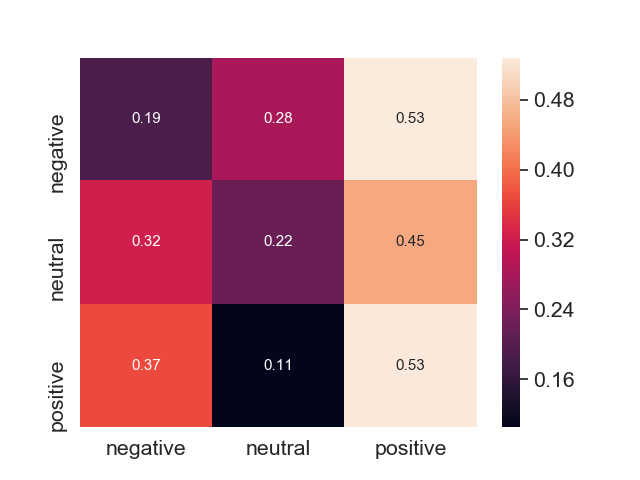

In [183]:
from sklearn.metrics import confusion_matrix

test_Y =( test_labels).astype(int)
# test_Y = [np.dot([0, 1, 2], ele) for ele in test_Y]
# print(test_Y)
    

labelList = ["negative", "neutral", "positive"]
test_Y_max=np.argmax(test_Y, axis=-1)
print(test_Y, test_Y_max)
print(test_Y_max)
cm=confusion_matrix(test_Y_max,output_labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = pd.DataFrame(cm, labelList,labelList )# matrix,names row,names col,
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 11}, fmt=".2f") # font size
plt.show()


In [184]:
from sklearn.metrics import classification_report
print("Classification Report\n",classification_report(test_Y_max, output_labels, labels=[0,1,2], target_names = labelList))

Classification Report
               precision    recall  f1-score   support

    negative       0.24      0.19      0.21        53
     neutral       0.50      0.22      0.31        77
    positive       0.14      0.53      0.22        19

   micro avg       0.25      0.25      0.25       149
   macro avg       0.29      0.31      0.24       149
weighted avg       0.36      0.25      0.26       149



# I have attached a file (part1.txt) of the results which I got when f1-score
# exceeded 65%. 

## Prediction base Embeddings
For prediction based embeddings we will use the IMDB dataset. We will create create our embeddings by using the unlabeledTrainData.tsv file.
We will use the Word2Vec model that we have already covered in class. 

### Preprocessing
Since we have already discussed preprocessing trade off's in previous assingments. We expect you to analyse the data and preform the preprocessing that is required.<br> 
<b> Hint: Each review is in string format so they have used slahes to escape characters and br tags to identify line breaks</b>

In [55]:
#following line is taken from internet
data = pd.read_csv("./word2vec-nlp-tutorial/labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
X0 = data['review'][:1000]
Y = data['sentiment'][:1000]
print(len(X0))

1000


# Due to Limited resources at home, I had to use less data for this part. I have reduced the data in the above cell. You can edit the above cell and make the code run for the complete data.

In [24]:
import re
def preprocess2(tweet):
    processed_data = tweet.lower()
    processed_data = re.sub("@[\S]+", "AT_TOKEN", processed_data)
    processed_data = re.sub("[#]", "", processed_data)
    processed_data = re.sub("<.*>", "", processed_data)
    processed_data = re.sub("[^a-zA-Z0-9\s_]", " ", processed_data)
    processed_data = re.sub("[\s]+", " ", processed_data)
    processed_data = re.sub("[_]{2,10}", "", processed_data)
    processed_data = processed_data.split(" ")
    return [x for x in processed_data if len(x) > 2]
def preprocessing2(data):
    new_data = [preprocess2(x) for x in data]
    print(len(new_data))
    tokens = []
    for ele in new_data: tokens += ele
    print(len(tokens))
    uni_toks = list(set(tokens))
    print(len(uni_toks))
    freq = []
    for tok in uni_toks: 
        if tokens.count(tok) == 1:
            freq += [tok]
    print(len(freq))
    for i, ele in enumerate(new_data):
        for fr in freq:
            ele = " ".join(ele)
            ele = ele.replace(fr, "UNK")
            ele = ele.split(" ")
        new_data[i] = ele
    return new_data
X = preprocessing2(X0)

1000
108788
13589
6781


Use the [gensim](https://radimrehurek.com/gensim/models/word2vec.html) to train a Word2Vec model. Keep the dimensionality at 300 and window size at 2. After trianing use the model and previously coded methods create vectorial represenations for movie reviews.<i>(create train_X, test_X, train_Y and test_Y)</i>

In [25]:
import gensim
def trainWord2Vec(data):
    """
    Return preprocessed data

    Args:
        data : movie reviews
    
    Returns: model
    model : Word2Vec model 
    """
    emb_len = 300
    model = gensim.models.Word2Vec(sentences=X, size = emb_len, window=2, min_count=1)
    return model
w2v_model = trainWord2Vec(X)
# print(w2v_model.)

In [26]:
#load the train and test files and create the vectorial representations
from sklearn.model_selection import train_test_split
train_X2, test_X2, train_Y2, test_Y2 = train_test_split(X, Y)

def create_X_train2(X, mod, pooling_func):
    tweet_vectors = []
    for tweet in X:
        tmp_tweet = []
        for word in tweet:
            tmp_tweet += [mod.wv[word]]
        tmp_tweet = np.array(tmp_tweet)
        pooled_tweet = pooling_func(tmp_tweet, tmp_tweet.shape)
        tweet_vectors += [pooled_tweet]
    return np.array(tweet_vectors)
cxt_train_2 = create_X_train2(train_X2, w2v_model, averagePooling)
print(cxt_train_2.shape)

(750, 300)


In [37]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
train_labels2 = enc.fit_transform([[x] for x in train_Y2]).toarray()
test_labels2 = enc.transform([[x] for x in test_Y2]).toarray()
print(train_Y2[:10], train_labels2[:10])

636    0
759    0
499    0
903    0
232    1
914    0
909    0
116    0
335    1
505    1
Name: sentiment, dtype: int64 [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


Since this is dense representaion we wont be faced with the challenges posed by sparse representations. We can move onto modelling.

### Modelling


In [30]:
import tensorflow as tf
from tensorflow import keras
embedding_size=300
model_word2vec = keras.Sequential([
    keras.layers.Flatten(input_shape=(embedding_size,)),#donot change(input layer)
    keras.layers.Dense(150, activation='relu'),#(hidden layer)
    keras.layers.Dense(50, activation='relu'),#(hidden layer)
    keras.layers.Dense(2)#donot change
])
model_word2vec.compile(optimizer='adam',
              loss=["categorical_crossentropy"],
              metrics=['accuracy'])

model_word2vec.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 300)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 150)               45150     
_________________________________________________________________
dense_4 (Dense)              (None, 50)                7550      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 102       
Total params: 52,802
Trainable params: 52,802
Non-trainable params: 0
_________________________________________________________________


In [31]:
model_word2vec.fit(cxt_train_2,train_labels2, epochs=15, batch_size=32,
               verbose=1,shuffle=True)

W0402 01:25:31.393048 139785117570880 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 750 samples
Epoch 1/15
750/750 [==============================] - 0s 211us/sample - loss: 7.6507 - accuracy: 0.4747
Epoch 2/15
750/750 [==============================] - 0s 58us/sample - loss: 7.6507 - accuracy: 0.4747
Epoch 3/15
750/750 [==============================] - 0s 69us/sample - loss: 7.6507 - accuracy: 0.4747
Epoch 4/15
750/750 [==============================] - 0s 64us/sample - loss: 7.6507 - accuracy: 0.4747
Epoch 5/15
750/750 [==============================] - 0s 60us/sample - loss: 7.6507 - accuracy: 0.4747
Epoch 6/15
750/750 [==============================] - 0s 64us/sample - loss: 7.6507 - accuracy: 0.4747
Epoch 7/15
750/750 [==============================] - 0s 84us/sample - loss: 7.6507 - accuracy: 0.4747
Epoch 8/15
750/750 [==============================] - 0s 59us/sample - loss: 7.6507 - accuracy: 0.4747
Epoch 9/15
750/750 [==============================] - 0s 55us/sample - loss: 7.6507 - accuracy: 0.4747
Epoch 10/15
750/750 [==============================

In [36]:
def predict(inp, mod):
    cxt_test_2 = create_X_train2(inp, w2v_model, averagePooling)
    print(cxt_train_2.shape)
    res = mod.predict(cxt_test_2)
    return res
predictions = predict(test_X2, model_word2vec)
print(predictions)
output_labels = []
for ele in predictions:
    index_max = max(range(len(ele)), key=ele.__getitem__)
    output_labels += [index_max]
print(output_labels)

(750, 300)
[[-0.38120782  0.07152706]
 [-0.33839476  0.06319195]
 [-0.34896532  0.0644771 ]
 [-0.35897148  0.06737418]
 [-0.37007782  0.06998251]
 [-0.34996837  0.0665479 ]
 [-0.3974258   0.07553319]
 [-0.283187    0.05274099]
 [-0.3395159   0.06280404]
 [-0.3370553   0.06221203]
 [-0.34813797  0.06596303]
 [-0.3457646   0.06482369]
 [-0.3983795   0.07526494]
 [-0.39207122  0.07336681]
 [-0.3143117   0.05824537]
 [-0.3663478   0.06857164]
 [-0.3455738   0.06398621]
 [-0.33922797  0.06347892]
 [-0.34987688  0.06524803]
 [-0.30450082  0.0571872 ]
 [-0.34229752  0.06398994]
 [-0.34025985  0.06364091]
 [-0.35326105  0.06545281]
 [-0.35045642  0.06533866]
 [-0.33505374  0.06272903]
 [-0.35625386  0.0671895 ]
 [-0.3369681   0.06365743]
 [-0.35728544  0.06690288]
 [-0.38781804  0.07259861]
 [-0.41520458  0.07775938]
 [-0.35812837  0.06695649]
 [-0.31861082  0.059261  ]
 [-0.32767168  0.06063295]
 [-0.3712328   0.06876837]
 [-0.34494102  0.06364924]
 [-0.36883107  0.0693505 ]
 [-0.29178113  0.

<IPython.core.display.Javascript object>


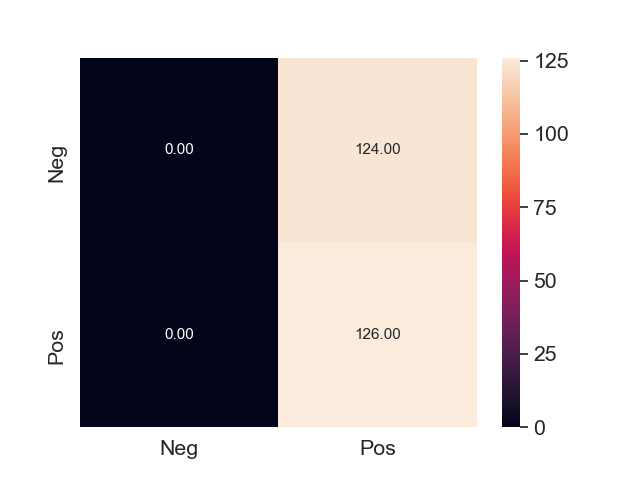

In [38]:
from sklearn.metrics import confusion_matrix

test_Y =(test_labels2).astype(int)

labelList = ["Neg", "Pos"]
test_Y_max=np.argmax(test_Y, axis=-1)
cm=confusion_matrix(test_Y_max,output_labels)
cm1 = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm1 = pd.DataFrame(cm, labelList,labelList )# matrix,names row,names col,
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm1, annot=True, annot_kws={"size": 11}, fmt=".2f") # font size
plt.show()


In [40]:
from sklearn.metrics import classification_report
print("Classification Report\n",classification_report(test_Y_max, output_labels, labels=[0,1], target_names = labelList))

Classification Report
               precision    recall  f1-score   support

         Neg       0.00      0.00      0.00       124
         Pos       0.50      1.00      0.67       126

   micro avg       0.50      0.50      0.50       250
   macro avg       0.25      0.50      0.34       250
weighted avg       0.25      0.50      0.34       250



/home/haseeb/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Theory
The two are two major reaserch papers [Word2Vec](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) for prediction based embeddings and [GloVe](https://nlp.stanford.edu/pubs/glove.pdf) for frequency based embeddings. Research online and write a short note on the trade offs associated with the two types of embeddings. 

###_______________Anwer________________###

Word2Vec does incremental and sparse training. It repeatedly iterates over the corpus. 

Glove on the other hand, fits vectors for modelling a giant co-occurences matrix of the corpus. It is based on matrix factorization techniques.

Difference in working:
GloVe takes a different approach than Word2Vec. Instead of extracting the embeddings from a neural network that is designed to perform a surrogate task (predicting neighbouring words), the embeddings are optimized directly so that the dot product of two word vectors equals the log of the number of times the two words will occur near each other (within 5 words for example). For example if "dog" and "cat" occur near each other 10 times in a corpus, then vec(dog) dot vec(cat) = log(10). This forces the vectors to somehow encode the frequency distribution of which words occur near them.

*Help taken from internet*

#### Ending Note:
Feed forward networks are not suitable for natural language task because of thier fixed input sizes, the size of natural language text in each example for a dataset can vary considerably, also feed forward networks ignore the temporal nature of natural language text, which result's in them not bieng able to caputre context's or interdepencies between words for semantic information. To fix this researcher's have invented recurrent neural networks that help to aleviate these limitations.
The next assignment will be related to recurrent neural networks.

# We hope all of you are working on your projects!